<a href="https://colab.research.google.com/github/Razvan183/PyTorch/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb

import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
record = wfdb.rdrecord('drive/MyDrive/database/113')
annotations = wfdb.rdann('drive/MyDrive/database/113', 'atr')

In [ ]:
print(np.unique(annotations.symbol))

['+' 'N' 'a']


In [ ]:
annotations_symbol_np = np.array(annotations.symbol)

In [ ]:
r_peaks = annotations.sample
print(r_peaks)

[    22    170    583 ... 649364 649675 649994]


In [ ]:
window_size = 360  # 1 second window, you can adjust this based on the data

# Initialize an empty list to store the segmented beats
segments = []

# Segment the signal around each R-peak
for r in r_peaks:
    start_idx = r - window_size // 2  # 0.5 second before the R-peak
    end_idx = r + window_size // 2  # 0.5 second after the R-peak

    # Ensure indices are within bounds of the signal
    if start_idx >= 0 and end_idx < len(record.p_signal):
        segment = record.p_signal[start_idx:end_idx, 0]  # Extract the ECG signal (first channel)
        segments.append(segment)

# Convert the list of segments to a numpy array for easier manipulation
segments = np.array(segments)
print(segments)

[[-0.47  -0.47  -0.465 ... -0.29  -0.275 -0.29 ]
 [-0.295 -0.31  -0.32  ... -0.255 -0.255 -0.265]
 [-0.26  -0.26  -0.26  ... -0.675 -0.665 -0.66 ]
 ...
 [-0.195 -0.22  -0.23  ... -0.195 -0.195 -0.17 ]
 [-0.21  -0.195 -0.195 ... -0.2   -0.19  -0.21 ]
 [-0.01  -0.05  -0.065 ... -0.24  -0.24  -0.255]]


In [ ]:
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply bandpass filter (0.5 Hz to 50 Hz)
filtered_segments = [butter_bandpass_filter(segment, 0.5, 50, 360) for segment in segments]


In [ ]:
# Normalize the segments (zero mean, unit variance)
normalized_segments = (filtered_segments - np.mean(filtered_segments, axis=1, keepdims=True)) / np.std(filtered_segments, axis=1, keepdims=True)
normalized_segments = np.array(normalized_segments)
print(len(normalized_segments))

1793


In [ ]:
normal_symbols = ['N']
abnormal_symbols = ['A', 'V', '+']

In [ ]:
beat_classification = []

for symbol in annotations_symbol_np:
    if symbol in normal_symbols:
        beat_classification.append(0)
    elif symbol in abnormal_symbols:
        beat_classification.append(1)
    else:
        beat_classification.append(2)

In [ ]:
# Create segment_labels based on annotations.sample
segment_labels = {}
for i, sample in enumerate(annotations.sample):
    if 0 <= i < len(beat_classification):  # Ensure i is within bounds of beat_classification
        segment_labels[sample] = beat_classification[i]
    else:
        print(f"Warning: No classification found for sample {sample} at index {i}")

# ... (Rest of your plotting code) ...

In [ ]:
# prompt: print how many 0s and 1s there are in beat_classification

print(f"Number of 0s: {beat_classification.count(0)}")
print(f"Number of 1s: {beat_classification.count(1)}")
for item, key in segment_labels.items():
  if key == 1:
    print(f"R-peak index: {item}, Beat classification: {key}")

Number of 0s: 1789
Number of 1s: 1
R-peak index: 22, Beat classification: 1


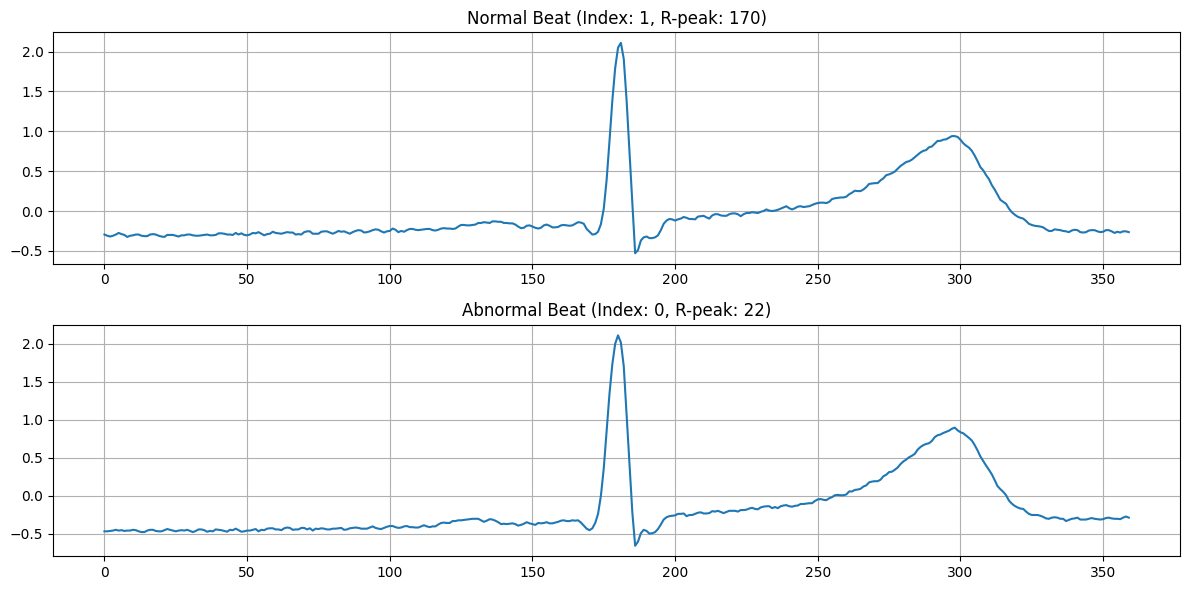

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'segments', 'r_peaks', and 'segment_labels' are defined

# Find indices of a normal and an abnormal beat
normal_index = next((i for i, r_peak in enumerate(r_peaks) if segment_labels.get(r_peak) == 0), None)
abnormal_index = next((i for i, r_peak in enumerate(r_peaks) if segment_labels.get(r_peak) == 1), None)

# Check if both indices were found
if normal_index is not None and abnormal_index is not None:
    # Plot the segments
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)  # Create subplot for normal beat
    plt.plot(segments[normal_index])
    plt.title(f"Normal Beat (Index: {normal_index}, R-peak: {r_peaks[normal_index]})")
    plt.grid(True)

    plt.subplot(2, 1, 2)  # Create subplot for abnormal beat
    plt.plot(segments[abnormal_index])
    plt.title(f"Abnormal Beat (Index: {abnormal_index}, R-peak: {r_peaks[abnormal_index]})")
    plt.grid(True)

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()
else:
    print("Could not find both normal and abnormal beats in the data.")